<a href="https://colab.research.google.com/github/eflores5000/estrategia2/blob/main/RNN_con_trainX1_de_Imagenet100_MobileNetV2_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
!pip install -q -U keras-tuner
import tensorflow as tf
from keras.datasets import mnist
from keras import layers, models
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
from keras.callbacks import Callback
import kerastuner as kt
from keras import callbacks
from keras import optimizers
from keras import models
from google.colab import files
!pip install quickdraw
from quickdraw import QuickDrawData
from google.colab import output
import os
import math
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import MobileNetV2


In [29]:
# Nos aseguramos que tenemos instalada la √∫ltima versi√≥n de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 173.2/173.2 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2


In [30]:
#%%capture
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()
#uploaded = files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eduflowers","key":"8cf8eb7e9d3d4d836fe29bda7df108d9"}'}

In [42]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‚Äò/root/.kaggle‚Äô: File exists


In [43]:
# Descarguemos un dataset de cierta competici√≥n
#!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("ifigotin/imagenetmini-1000")

path = kagglehub.dataset_download("ambityga/imagenet100")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ambityga/imagenet100/versions/8


In [45]:
# Creemos un directorio para descomprimir los datos
!cp -r /root/.cache/kagglehub/datasets/ambityga/imagenet100/versions/8 my_dataset
#!mkdir my_dataset

In [35]:
# Descomprimimos los datos y los dejamos listos para trabajar
!unzip dogs-vs-cats-redux-kernels-edition.zip -d my_dataset
!unzip my_dataset/test.zip
%%capture
!ls test/


Mounted at /content/drive


In [36]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

mkdir: cannot create directory ‚Äòmy_dataset‚Äô: File exists


[INFO]: Clases disponibles: ['n01440764', 'n01484850', 'n01494475', 'n01531178', 'n01632777', 'n01665541', 'n01687978', 'n01695060', 'n01749939', 'n01775062', 'n01795545', 'n01818515', 'n01820546', 'n01824575', 'n01833805', 'n01914609', 'n01924916', 'n01930112', 'n01950731', 'n01978455', 'n01984695', 'n02007558', 'n02012849', 'n02018795', 'n02037110']


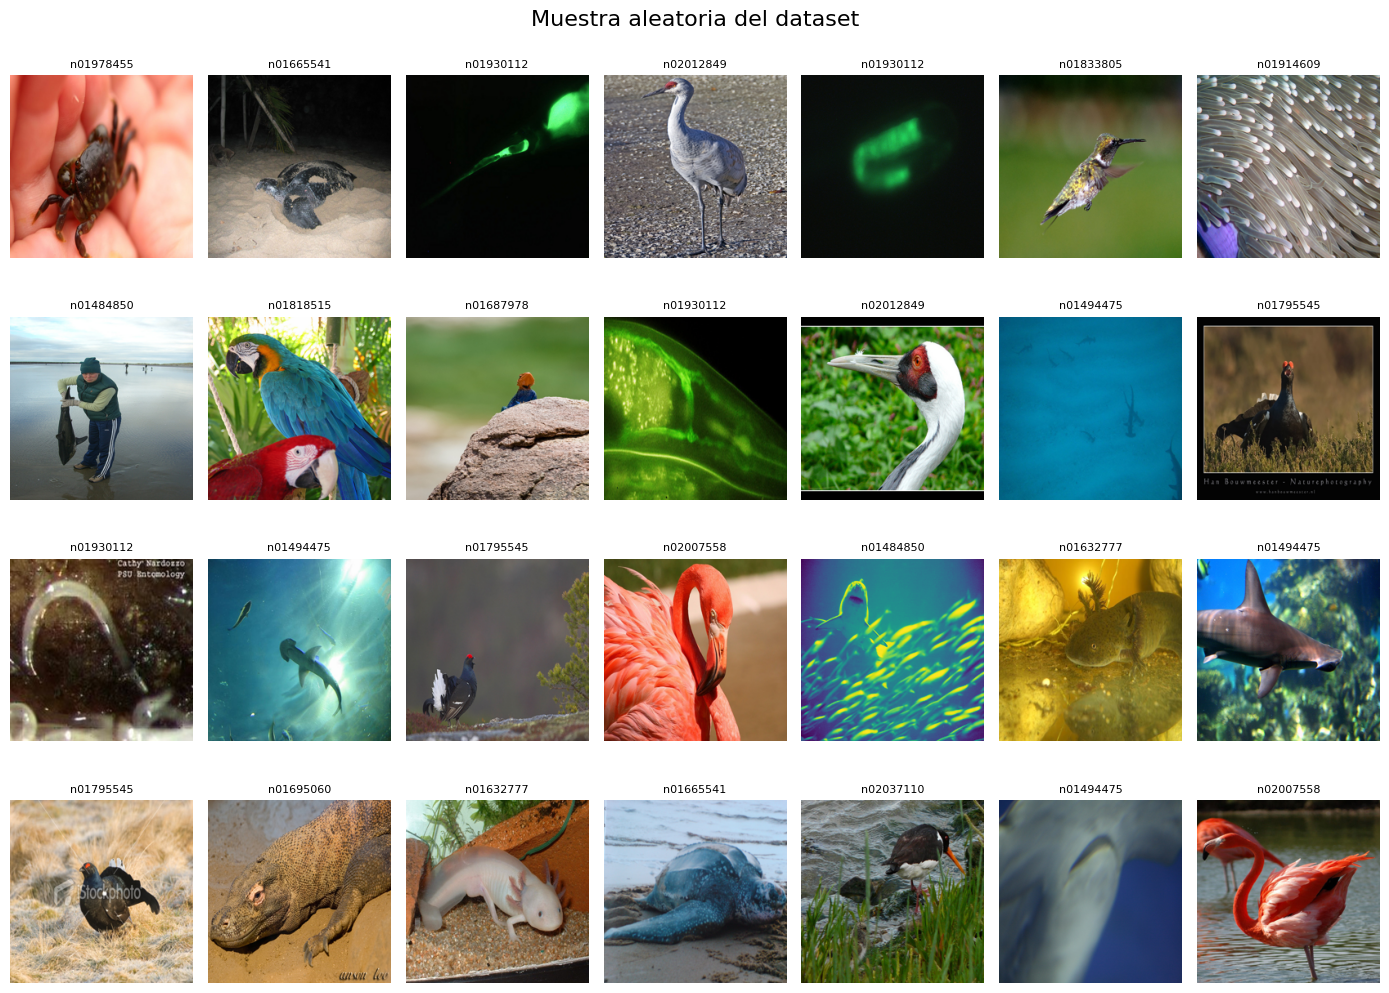

In [46]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

# Ruta al dataset de entrenamiento
train_path = '/content/my_dataset/8/train.X1'

# Obtener solo carpetas (clases) v√°lidas
clases = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
print(f"[INFO]: Clases disponibles: {clases}")

# Preparar lista de (imagen, etiqueta)
ejemplos = []
for clase in clases:
    ruta_clase = os.path.join(train_path, clase)
    imagenes = [f for f in os.listdir(ruta_clase) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img in imagenes:
        ejemplos.append((os.path.join(ruta_clase, img), clase))

# Seleccionar aleatoriamente 28 im√°genes
muestras = random.sample(ejemplos, 28)

# Visualizaci√≥n tipo CIFAR-10
fig = plt.figure(figsize=(14, 10))
for i, (ruta_img, etiqueta) in enumerate(muestras):
    fig.add_subplot(4, 7, i+1)
    img = Image.open(ruta_img).resize((224, 224))
    plt.imshow(img)
    plt.title(etiqueta, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Muestra aleatoria del dataset", fontsize=16, y=1.02)
plt.show()

In [54]:
#limitar√© el dataset a 25 clases.
import os
import shutil

#eliminado directorio previo
#rm -r /content/my_dataset/8/val.X1

# Ruta de origen y destino (ajusta seg√∫n tu caso)
directorios = '/content/my_dataset/8/train.X1'
origen = '/content/my_dataset/8/val.X'
destino = '/content/my_dataset/8/val.X1'

# Crear carpeta destino si no existe
os.makedirs(destino, exist_ok=True)

# Listar subdirectorios (solo carpetas)
subdirs = [d for d in os.listdir(directorios) if os.path.isdir(os.path.join(origen, d))]
#subdirs.sort()  # Opcional: ordenar alfab√©ticamente

# Copiar los primeros 25 directorios
for d in subdirs[:25]:
    src_path = os.path.join(origen, d)
    dst_path = os.path.join(destino, d)
    shutil.copytree(src_path, dst_path)
    print(f"‚úÖ Copiado: {d}")


‚úÖ Copiado: n01930112
‚úÖ Copiado: n01695060
‚úÖ Copiado: n01749939
‚úÖ Copiado: n01824575
‚úÖ Copiado: n01775062
‚úÖ Copiado: n01665541
‚úÖ Copiado: n01924916
‚úÖ Copiado: n02018795
‚úÖ Copiado: n01494475
‚úÖ Copiado: n02012849
‚úÖ Copiado: n01795545
‚úÖ Copiado: n01984695
‚úÖ Copiado: n01687978
‚úÖ Copiado: n01484850
‚úÖ Copiado: n01440764
‚úÖ Copiado: n01978455
‚úÖ Copiado: n01632777
‚úÖ Copiado: n02007558
‚úÖ Copiado: n01914609
‚úÖ Copiado: n01820546
‚úÖ Copiado: n01818515
‚úÖ Copiado: n01531178
‚úÖ Copiado: n02037110
‚úÖ Copiado: n01833805
‚úÖ Copiado: n01950731


In [152]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

classes = subdirs
imgs_w = 224
imgs_h = 224

train_dir_base = '/content/my_dataset/8/train.X1'
val_dir_base = '/content/my_dataset/8/val.X1'

# Usamos un ‚Äúdata generator‚Äù para tener un dataset m√°s grande.
# B√°sicamente √©sto lo que hace es crear im√°genes nuevas a partir del dataset original.
# Lo hace aplicando transformaciones como zoom, traslaci√≥n o rotaci√≥n.

# Preprocesamiento espec√≠fico para MobileNetV2
# Para entrenamiento
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Para validaci√≥n (lo mismo)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split = 0.2)

# Preprocesamiento espec√≠fico para MobileNetV2
train_generator = train_datagen.flow_from_directory(
  train_dir_base,
  target_size = (imgs_w,imgs_h),
  batch_size = 128,
  class_mode = 'categorical',
  color_mode = 'rgb',
  subset = 'training'
)
val_generator = test_datagen.flow_from_directory(
  val_dir_base,
  target_size = (imgs_w,imgs_h),
  batch_size = 128,
  class_mode = 'categorical',
  color_mode = 'rgb',
  subset = 'validation'
)
test_generator = test_datagen.flow_from_directory(
  val_dir_base,
  target_size = (imgs_w,imgs_h),
  batch_size = 128,
  class_mode = 'categorical',
  color_mode = 'grayscale'
)


Found 32500 images belonging to 25 classes.
Found 250 images belonging to 25 classes.
Found 1250 images belonging to 25 classes.


In [162]:
# Buscamos los hyperpar√°metros ideales para nuestro modelo.

def model_generator(hp):

  # Cargar MobileNetV2 preentrenado
  base_model = MobileNetV2(
      weights='imagenet',
      include_top=False,
      input_shape=(imgs_w,imgs_h, 3),
      alpha=1.0  # Width multiplier (1.0 = versi√≥n completa)
  )
  # Congelar inicialmente
  base_model.trainable = False

  # numero filtros convoluciones
  filters = hp.Choice('filters', values=[32, 64, 128]) #numero de neuronas
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_units = hp.Int('units', min_value = 32, max_value=512, step=32) # hidden layers:
  #hp_units = hp.Int('units', min_value=64, max_value=512, step=64)

  # Arquitectura optimizada para MobileNetV2
  inputs = tf.keras.Input(shape=(imgs_w,imgs_h, 3))
  x = base_model(inputs, training=False)

  #model = models.Sequential() # convolution layers:

  # Bloque 1
  x=layers.Conv2D(filters, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  x=layers.Conv2D(filters, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  print(x.shape)
  x=layers.MaxPool2D((2,2))(x)

  # Bloque 2
  x=layers.Conv2D(filters*2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  x=layers.Conv2D(filters*2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  print(x.shape)
  x=layers.MaxPool2D((2,2))(x)
  x=layers.Dropout(0.3)(x)

  # Bloque 3
  x=layers.Conv2D(filters*4, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  x=layers.Conv2D(filters*4, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  print(x.shape)
  #x=layers.MaxPool2D((2,2))(x)
  x=layers.Dropout(0.4)(x)  # capa del input del clasificador:

  # Clasificador
  x=layers.Flatten()(x)     #numero de neuronas

  # Red oculta opcional:
  x=layers.Dense(units = hp_units, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
  #x=layers.Dense(units = int(hp_units/2), activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)

  x=layers.Dropout(0.2)(x) # output layer

  # Capa de salida
  outputs=layers.Dense(len(classes),activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  # Compilaci√≥n
  model.compile(optimizer= optimizers.Adam(learning_rate=hp_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
  return model

tuner = kt.Hyperband(
  model_generator,
  objective = 'val_accuracy',
  max_epochs = 20,
  directory = 'models',
  project_name = 'psm'
)

tuner.search(train_generator, epochs = 20, validation_data=val_generator)
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps)

# Mejor combinaci√≥n
print(f"üîé Mejores hiperpar√°metros encontrados:")
print(f"  - Filtros: {best_hps.get('filters')}")
print(f"  - Learning rate: {best_hps.get('learning_rate')}")
#print(f"  - Neuronas en capa densa: {best_hps.get('units')}")


Reloading Tuner from models/psm/tuner0.json
üîé Mejores hiperpar√°metros encontrados:
  - Filtros: 128
  - Learning rate: 0.0001


In [163]:
# Por aqu√≠ personalizamos un callback que se llamar√° cada √©poca para detener el
# entrenamiento si llegamos al 0.99 de accuracy en los datos de validaci√≥n.

class TrainingCallback(Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.99:
      print('Model reached 99,9% of accuracy. Stopping training.')
      self.model.stop_training = True


In [164]:
#Configuramos el criterio para guardar los pesos del modelo para que se guarde el
#punto del entrenamiento con mejor accuracy en los datos de validaci√≥n.

checkpoint_save = callbacks.ModelCheckpoint(
  filepath = 'model_checkpoints/checkpoint.h5',
  save_freq = 'epoch',
  save_weights_only = False,
  monitor = 'val_accuracy',
  save_best_only = True,
  verbose = 1
)

# Verificaci√≥n
print(f"N√∫mero de clases en train: {train_generator.num_classes}")
print(f"N√∫mero de clases en val: {val_generator.num_classes}")
print(f"Mapping de clases: {train_generator.class_indices}")
print(f"Mapping de clases: {val_generator.class_indices}")

N√∫mero de clases en train: 25
N√∫mero de clases en val: 25
Mapping de clases: {'n01440764': 0, 'n01484850': 1, 'n01494475': 2, 'n01531178': 3, 'n01632777': 4, 'n01665541': 5, 'n01687978': 6, 'n01695060': 7, 'n01749939': 8, 'n01775062': 9, 'n01795545': 10, 'n01818515': 11, 'n01820546': 12, 'n01824575': 13, 'n01833805': 14, 'n01914609': 15, 'n01924916': 16, 'n01930112': 17, 'n01950731': 18, 'n01978455': 19, 'n01984695': 20, 'n02007558': 21, 'n02012849': 22, 'n02018795': 23, 'n02037110': 24}
Mapping de clases: {'n01440764': 0, 'n01484850': 1, 'n01494475': 2, 'n01531178': 3, 'n01632777': 4, 'n01665541': 5, 'n01687978': 6, 'n01695060': 7, 'n01749939': 8, 'n01775062': 9, 'n01795545': 10, 'n01818515': 11, 'n01820546': 12, 'n01824575': 13, 'n01833805': 14, 'n01914609': 15, 'n01924916': 16, 'n01930112': 17, 'n01950731': 18, 'n01978455': 19, 'n01984695': 20, 'n02007558': 21, 'n02012849': 22, 'n02018795': 23, 'n02037110': 24}


In [165]:
#Instanciamos el modelo con los par√°metros m√°s eficientes.
model = model_generator(best_hps)

(None, 7, 7, 128)
(None, 3, 3, 256)
(None, 1, 1, 512)


In [ ]:
#Si ya lo tuvi√©ramos guardado, lo gargar√≠amos del siguiente modo:
#model = models.load_model(‚Äúmodel_checkpoints/checkpoint‚Äù)


In [166]:
#print("\n--- Fase 1: Transfer Learning ---")

#Procedemos al entrenamiento:
train_epochs = 10
early_stop_patience = 3
train_history = model.fit(
  train_generator,
  epochs=train_epochs,
  batch_size=128,
  validation_data=val_generator,
  callbacks = [
  checkpoint_save,
  #TrainingCallback(),
  callbacks.EarlyStopping(monitor = 'val_loss', patience=10, mode = 'auto')
  ] )

Epoch 1/10
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 536ms/step - accuracy: 0.3484 - loss: 2.1853
Epoch 1: val_accuracy improved from -inf to 0.87600, saving model to model_checkpoints/checkpoint.h5


254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 171s 610ms/step - accuracy: 0.3494 - loss: 2.1820 - val_accuracy: 0.8760 - val_loss: 0.5036
Epoch 2/10
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 480ms/step - accuracy: 0.9104 - loss: 0.3620
Epoch 2: val_accuracy improved from 0.87600 to 0.88400, saving model to model_checkpoints/checkpoint.h5


254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 123s 485ms/step - accuracy: 0.9104 - loss: 0.3619 - val_accuracy: 0.8840 - val_loss: 0.5334
Epoch 3/10
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 478ms/step - accuracy: 0.9451 - loss: 0.2296
Epoch 3: val_accuracy improved from 0.88400 to 0.88800, saving model to model_checkpoints/checkpoint.h5


254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 123s 484ms/step - accuracy: 0.9451 - loss: 0.2296 - val_accuracy: 0.8880 - val_loss: 0.5339
Epoch 4/10
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 479ms/step - accuracy: 0.9600 - loss: 0.1722
Epoch 4: val_accuracy did not improve from 0.88800
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 123s 483ms/step - accuracy: 0.9600 - loss: 0.1722 - val_accuracy: 0.8880 - val_loss: 0.4255
Epoch 5/10
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 479ms/step - accuracy: 0.9677 - loss: 0.1361
Epoch 5: val_accuracy improved from 0.88800 to 0.89600, saving model to model_checkpoints/checkpoint.h5


254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 123s 485ms/step - accuracy: 0.9677 - loss: 0.1361 - val_accuracy: 0.8960 - val_loss: 0.5783
Epoch 6/10
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 476ms/step - accuracy: 0.9742 - loss: 0.1081
Epoch 6: val_accuracy improved from 0.89600 to 0.90800, saving model to model_checkpoints/checkpoint.h5


254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 123s 482ms/step - accuracy: 0.9742 - loss: 0.1081 - val_accuracy: 0.9080 - val_loss: 0.5906
Epoch 7/10
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 476ms/step - accuracy: 0.9819 - loss: 0.0842
Epoch 7: val_accuracy did not improve from 0.90800
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 122s 480ms/step - accuracy: 0.9819 - loss: 0.0842 - val_accuracy: 0.8920 - val_loss: 0.6645
Epoch 8/10
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 478ms/step - accuracy: 0.9855 - loss: 0.0672
Epoch 8: val_accuracy did not improve from 0.90800
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 123s 483ms/step - accuracy: 0.9855 - loss: 0.0672 - val_accuracy: 0.8960 - val_loss: 0.6533
Epoch 9/10
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 478ms/step - accuracy: 0.9877 - loss: 0.0565
Epoch 9: val_accuracy improved 

254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 123s 484ms/step - accuracy: 0.9877 - loss: 0.0565 - val_accuracy: 0.9160 - val_loss: 0.5079
Epoch 10/10
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 478ms/step - accuracy: 0.9875 - loss: 0.0596
Epoch 10: val_accuracy did not improve from 0.91600
254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 123s 483ms/step - accuracy: 0.9875 - loss: 0.0596 - val_accuracy: 0.8960 - val_loss: 0.6842


In [167]:
#Guardamos el modelo: ¬°Qu√© no se pierda!
!zip -r /content/model_checkpoint.zip /content/model_checkpoints
files.download('/content/model_checkpoint.zip')


updating: content/model_checkpoints/ (stored 0%)
updating: content/model_checkpoints/checkpoint.h5 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [168]:
#Observamos los resultados:

results = model.evaluate(train_generator)

254/254 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 126s 496ms/step - accuracy: 0.9921 - loss: 0.0366


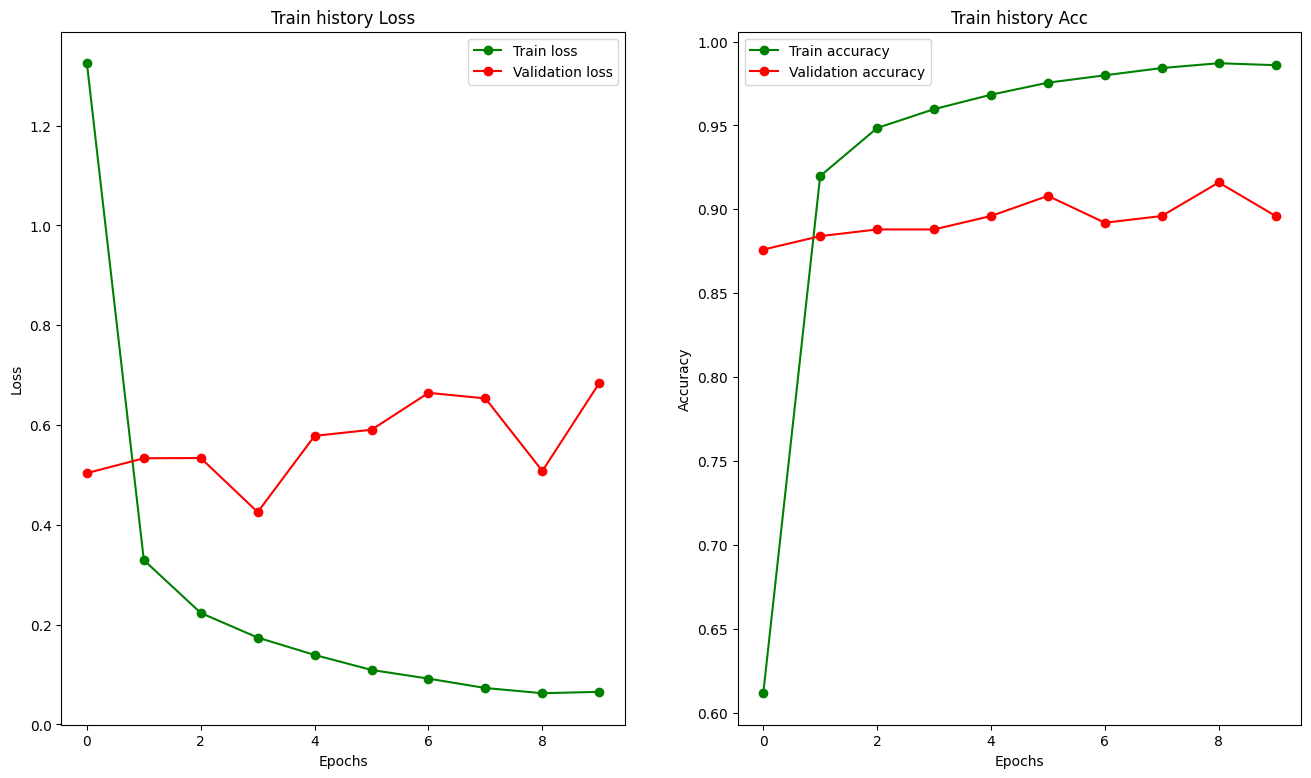

In [169]:
# Funci√≥n para graficar entrenamiento:

#@title Funci√≥n para graficar entrenamiento
def show_train_history(history, show_acc = True):
  epochs = [i for i in range(len(history.history['accuracy']))]
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig, ax = plt.subplots(1, 2 if show_acc else 1)
  fig.set_size_inches(16 if show_acc else 10, 9)
  if show_acc:
    ax[1].plot(epochs, train_acc, 'go-', label = 'Train accuracy')
    ax[1].plot(epochs, val_acc, 'ro-', label = 'Validation accuracy')
    ax[1].set_title('Train history Acc')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[0].plot(epochs, train_loss, 'go-', label = 'Train loss')
    ax[0].plot(epochs, val_loss, 'ro-', label = 'Validation loss')
    ax[0].set_title('Train history Loss')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
  else:
    ax.plot(epochs, train_loss, 'go-', label = 'Train loss')
    ax.plot(epochs, val_loss, 'ro-', label = 'Validation loss')
    ax.set_title('Train history Loss')
    ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
  plt.show()

show_train_history(train_history)